### Trying to write something that is actually helpful here. Let's look at the perfectly perpendicular case. Start by loading in data

In [2]:
import osh5io
import osh5vis
import osh5io

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src/vysxd')

In [3]:
data_dir = Path('..') / "simulations" / "raw_data" / "magshockz-v3.2-internal_fields-7.14debye.1d" / "MS"
assert data_dir.exists(), f"Data directory {data_dir} does not exist."
print(f"Using data directory: {data_dir}")

Using data directory: ../simulations/raw_data/magshockz-v3.2-internal_fields-7.14debye.1d/MS


In [4]:
def get_data_at_t(data_dir, path_to_field, t, ion_inertial_length=np.sqrt(400)):
    """
    Gets data and scales x axis to ion inertial length.
    """
    sorted_files = sorted((data_dir / path_to_field).glob('*.h5'))
    data = osh5io.read_h5(sorted_files[t].as_posix())
    if len(np.shape(data)) == 1:
        data.scale_x_axis(1/ion_inertial_length)
    return data


### First, let's measure the shock speed/Mach number of the propogating shock

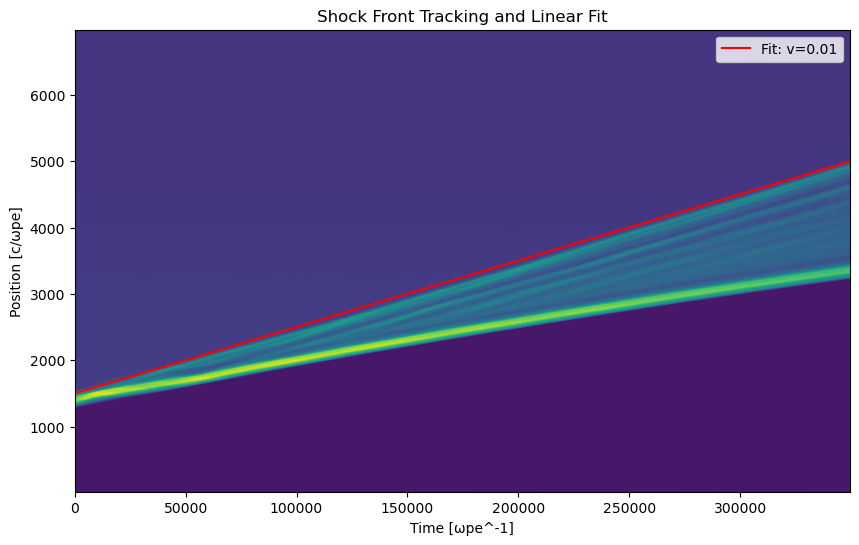

In [5]:
from scipy.optimize import curve_fit
import vysxd_analysis
import vysxd_define

# Find the shock front position at each time step by locating the maximum gradient
shock_front_positions = []
shock_front_times = []

b2_t = vysxd_analysis.get_osiris_quantity_1d(data_dir.as_posix() + '/FLD/b2-savg/')

left = 100
right = -100

Q = -b2_t[0][:, left:right]
times = b2_t[3]
positions = b2_t[4][left:right]

linear = lambda x, v, x0: v * (x) + x0
v = 0.01
x0 = 1500

plt.figure(figsize=(10, 6))
plt.imshow(Q.T, origin='lower', aspect='auto', extent=[times[0], times[-1], positions[0], positions[-1]])
# plt.plot(shock_front_positions, shock_front_times, 'r.', label='Shock front')
plt.plot(times, linear(times, v, x0), label=f'Fit: v={v:.2f}',c = 'red')
plt.ylabel('Position [c/ωpe]')
plt.xlabel('Time [ωpe^-1]')
plt.legend()
plt.title('Shock Front Tracking and Linear Fit')
plt.show()


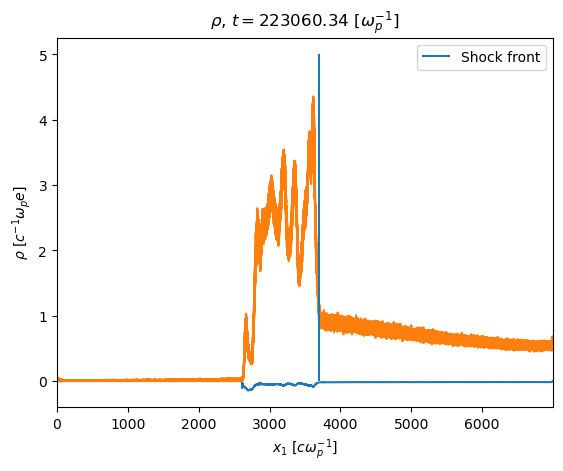

In [6]:
t = 120
b2 = sorted(Path(data_dir / 'FLD' / 'b2-savg').glob('*.h5'))
b2_data = [osh5io.read_h5(f.as_posix()) for f in b2]
osh5vis.osplot(b2_data[t])

channel = sorted(Path(data_dir / 'DENSITY' / 'channel' / 'charge').glob('*.h5'))
channel_data = [osh5io.read_h5(f.as_posix()) for f in channel]
osh5vis.osplot(channel_data[t])

plt.vlines(3700,ymin = 0, ymax = 5, label = "Shock front")
plt.legend()

In [7]:
# Alright. Looks like that ish is moving at .01c, let's calculate the Mach number from that.

rqm = 380
t = 0
index = -10

v_A = np.abs(b2_data[t][index]) / np.sqrt(rqm * channel_data[t][index])
print (f"Mach number is approx. {v / v_A:.2f} for v={v:.2f} and v_A={v_A:.5f}")

Mach number is approx. 8.56 for v=0.01 and v_A=0.00117


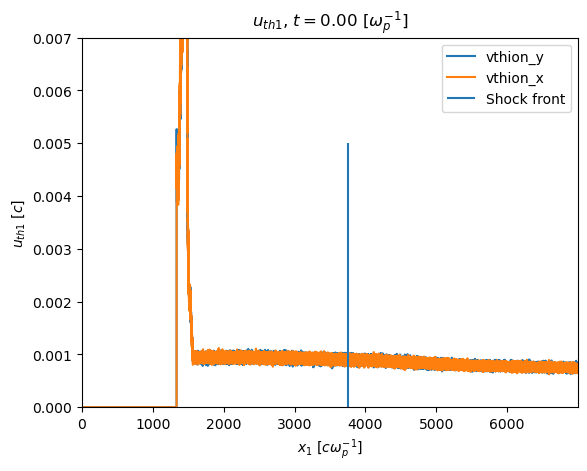

In [8]:
# What about heating? 
t = 0
xlims = (2600, -1)
vthion_x = sorted(Path(data_dir / 'UDIST' / 'channel'/ 'uth1').glob('*.h5'))
vthion_x_data = [osh5io.read_h5(f.as_posix()) for f in vthion_x]

vthion_y = sorted(Path(data_dir / 'UDIST' / 'channel'/ 'uth2').glob('*.h5'))
vthion_y_data = [osh5io.read_h5(f.as_posix()) for f in vthion_y]

osh5vis.osplot(vthion_y_data[t], label = 'vthion_y')
osh5vis.osplot(vthion_x_data[t], label = 'vthion_x')
# plt.xlim(xlims[0], xlims[1])
plt.vlines(3750, ymin=0, ymax=.005, label='Shock front')
plt.ylim(0, 0.007)

plt.legend()

Heating looks super anisotropic... is that right?

Let's look at the electrons

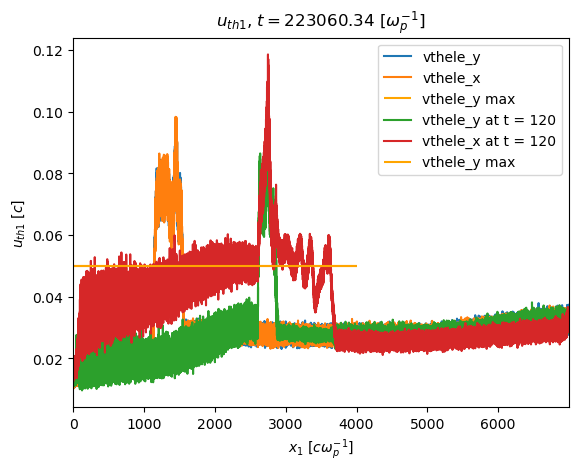

In [9]:
vthele_x = sorted(Path(data_dir / 'UDIST' / 'electrons'/ 'uth1').glob('*.h5'))
vthele_x_data = [osh5io.read_h5(f.as_posix()) for f in vthele_x]
vthele_y = sorted(Path(data_dir / 'UDIST' / 'electrons'/ 'uth2').glob('*.h5'))
vthele_y_data = [osh5io.read_h5(f.as_posix()) for f in vthele_y]

osh5vis.osplot(vthele_y_data[t], label = 'vthele_y')
osh5vis.osplot(vthele_x_data[t], label = 'vthele_x')

plt.hlines(0.05, xmin = 0, xmax = 4000, label='vthele_y max', color='orange')
# plt.xlim(0, 4000)
plt.legend()
t = 120
vthele_x = sorted(Path(data_dir / 'UDIST' / 'electrons'/ 'uth1').glob('*.h5'))
vthele_x_data = [osh5io.read_h5(f.as_posix()) for f in vthele_x]
vthele_y = sorted(Path(data_dir / 'UDIST' / 'electrons'/ 'uth2').glob('*.h5'))
vthele_y_data = [osh5io.read_h5(f.as_posix()) for f in vthele_y]

osh5vis.osplot(vthele_y_data[t], label = f'vthele_y at t = {t}')
osh5vis.osplot(vthele_x_data[t], label = f'vthele_x at t = {t}')

plt.hlines(0.05, xmin = 0, xmax = 4000, label='vthele_y max', color='orange')
# plt.xlim(0, 4000)
plt.legend()

In [25]:
# let's say that the downstream electron temperature is 0.05c, putting this into eV gives us

m_e = 9.10938356e-28  # electron mass in grams
c = 3e10 # speed of light in cm/s
vth = 0.05  # thermal velocity in cm/s
erg_per_eV = 1.602176634e-12  # conversion factor from eV to erg
T = vth**2 * m_e * c**2
print(f"Downstream electron temperature in x direction is {T / erg_per_eV} eV")

# Now let's look at the ion temperature
vthion = 0.004
T = vthion**2 * rqm * m_e * c**2
print(f"Downstream ion temperature in x direction is {T / erg_per_eV} eV")

Downstream electron temperature in x direction is 1279.2667534308832 eV
Downstream ion temperature in x direction is 3111.1767443439076 eV
